In [1]:
import pandas as pd
import sys
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from sklearn.linear_model import LogisticRegression

sns.set_style('darkgrid')

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

from forseti.datproc import translate_categorical, extract_sensitive, encode_dummies

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Exploration

As a preliminary study of the data. We will perform some data visualisation, 
calculate some biases in the data and fit som simple models.

Firstly, let's import the data 

In [2]:
# %% Translate Categorical Attributes
df = pd.read_csv('data/adult.csv')
tmp, codes = translate_categorical(df.copy(deep=True))

In [3]:
dummy = encode_dummies(df.copy(deep=True))
dummy.head()

,age,capital-gain,hours-per-week,workclass.Local-gov,workclass.Never-worked,workclass.Private,workclass.Self-emp-inc,workclass.Self-emp-not-inc,workclass.State-gov,workclass.Without-pay,...,native-country.Puerto-Rico,native-country.Scotland,native-country.South,native-country.Taiwan,native-country.Thailand,native-country.Trinadad&Tobago,native-country.United-States,native-country.Vietnam,native-country.Yugoslavia,income.>50K
0,25,0,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,38,0,50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,28,0,40,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,44,7688,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,18,0,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## Influence on income

Let's find the features that have the highest and lowest correlation with income.

### The 10 most important features with negative correlation

In [4]:
corr = dummy.corr()['income.>50K'].sort_values()
print(corr[:10].to_latex())

\begin{tabular}{lr}
\toprule
{} &  income.>50K \\
\midrule
marital-status.Never-married &    -0.318782 \\
relationship.Own-child       &    -0.225691 \\
relationship.Not-in-family   &    -0.190372 \\
occupation.Other-service     &    -0.155254 \\
relationship.Unmarried       &    -0.143642 \\
education.HS-grad            &    -0.130706 \\
race.Black                   &    -0.090448 \\
education.11th               &    -0.086728 \\
relationship.Other-relative  &    -0.085601 \\
occupation.Handlers-cleaners &    -0.085189 \\
\bottomrule
\end{tabular}



### The 10 most important features with positive correlation

In [5]:
print(corr[-10:].to_latex())

\begin{tabular}{lr}
\toprule
{} &  income.>50K \\
\midrule
education.Masters                 &     0.174184 \\
education.Bachelors               &     0.180371 \\
occupation.Prof-specialty         &     0.188793 \\
occupation.Exec-managerial        &     0.210938 \\
capital-gain                      &     0.214356 \\
gender.Male                       &     0.214628 \\
hours-per-week                    &     0.227687 \\
age                               &     0.230369 \\
marital-status.Married-civ-spouse &     0.445853 \\
income.>50K                       &     1.000000 \\
\bottomrule
\end{tabular}



### The most important attributes

We see these features are the ones with the highest correlation to income

- marital-status (both negative and positive correlation)
- age (positive correlation)
- hours per week (positive correlation)
- capital-gain (positive relationship)
- occupation (positive and negative relationship)
- relationship (negative relationship)
- education (positive and negative relationship)
- gender (positive relationship if male)
- race (negative relationship if black)

The two last features is concerning. This means that the weighted dataset
is biased and violates demograhic parity. i.e

$$
P(Y=1 | gender=male) = P(Y=1 | gender=female)
$$

which is not the case if beeing male is positively correlated with income.

# Let's Explore attributes relationship to income

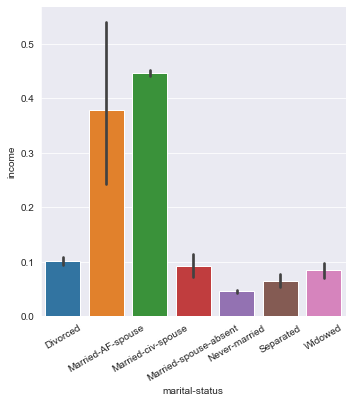

In [6]:
attr = 'marital-status'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

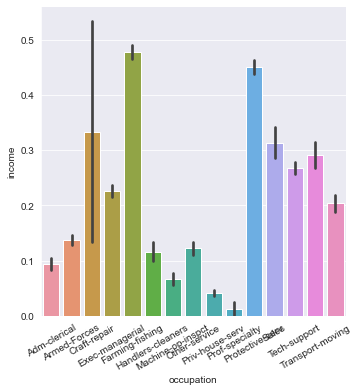

In [7]:
attr = 'occupation'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

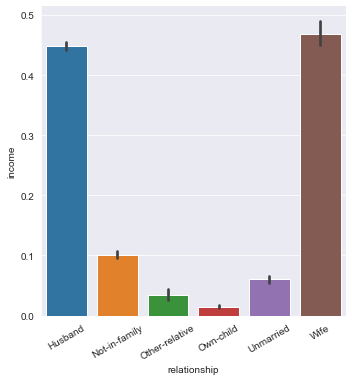

In [10]:
attr = 'relationship'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

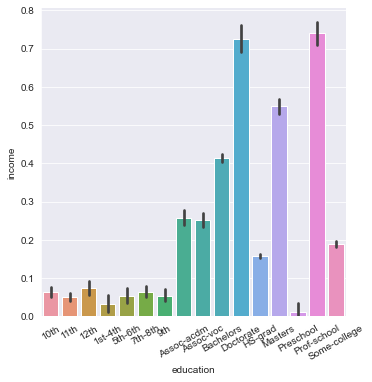

In [11]:
attr = 'education'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

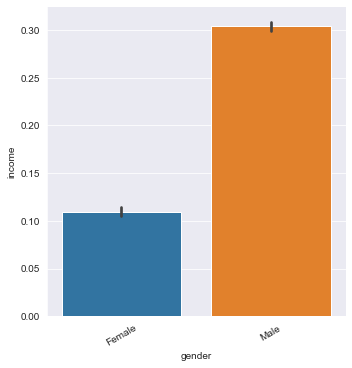

In [12]:
attr = 'gender'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

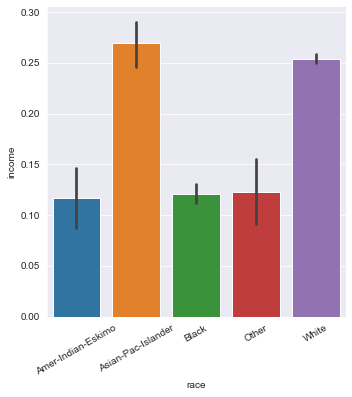

In [13]:
attr = 'race'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

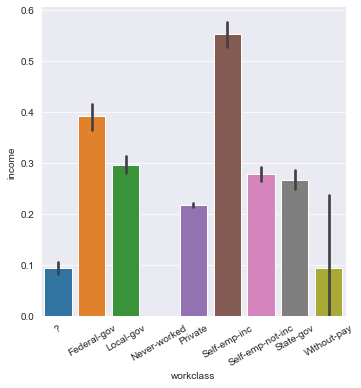

In [14]:
attr = 'workclass'
sns.catplot(x=attr, y='income', kind='bar', data=tmp)
plt.xticks(list(codes[attr].keys()), list(codes[attr].values()), rotation=30);

## Train Interpretable Model

Let's train a logistic-regresion model and interpret it's weights

In [9]:
attributes = [
    'marital-status',
    'age',
    'hours-per-week',
    'capital-gain',
    'occupation',
    'relationship',
    'education',
    'gender',
    'race',
    'income'
]

dummy = encode_dummies(df[attributes])

X = dummy.drop('income.>50K', axis=1)
y = dummy['income.>50K']

clf = LogisticRegression(random_state=0).fit(X, y);

odds = pd.DataFrame(
    {
        'Attribute': X.columns,
        'Odds': np.exp(clf.coef_)[0]
    }
);

C:\tools\Anaconda3\envs\forseti\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Top 5 weights

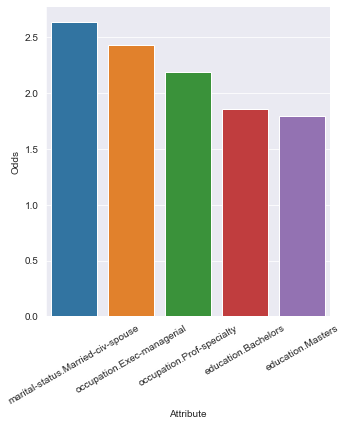

In [12]:
odds = odds.sort_values(by='Odds', ascending=False)
sns.catplot(x='Attribute', y='Odds', kind='bar', data=odds[:5])
plt.xticks(rotation=30);

## Bottomn 5 weights

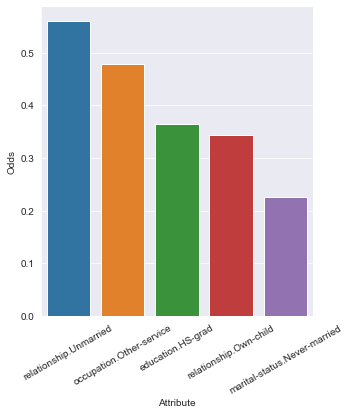

In [13]:
sns.catplot(x='Attribute', y='Odds', kind='bar', data=odds[-5:])
plt.xticks(rotation=30);